### Imports

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as lm
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


### Funções

In [2]:
def load_data(file_path):
    return pd.read_parquet(file_path)

def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values    
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def create_classification_report_df(class_reports,model_names):
    if len(class_reports) != len(model_names):
        raise ValueError("O número de relatórios de classificação deve ser igual ao número de nomes de modelos.")
    
    all_reports = []

    for report, model_name in zip(class_reports, model_names):
        # Verificar se as chaves esperadas existem no relatório
        data = {
            'Model': model_name,
            'Accuracy': report.get('accuracy', None),
            'Class 0 Precision': report.get('0', {}).get('precision', None),
            'Class 0 Recall': report.get('0', {}).get('recall', None),
            'Class 0 F1-Score': report.get('0', {}).get('f1-score', None),
            'Class 1 Precision': report.get('1', {}).get('precision', None),
            'Class 1 Recall': report.get('1', {}).get('recall', None),
            'Class 1 F1-Score': report.get('1', {}).get('f1-score', None),
            'Class 2 Precision': report.get('2', {}).get('precision', None),
            'Class 2 Recall': report.get('2', {}).get('recall', None),
            'Class 2 F1-Score': report.get('2', {}).get('f1-score', None),
            'Macro Avg Precision': report.get('macro avg', {}).get('precision', None),
            'Macro Avg Recall': report.get('macro avg', {}).get('recall', None),
            'Macro Avg F1-Score': report.get('macro avg', {}).get('f1-score', None),
            'Weighted Avg Precision': report.get('weighted avg', {}).get('precision', None),
            'Weighted Avg Recall': report.get('weighted avg', {}).get('recall', None),
            'Weighted Avg F1-Score': report.get('weighted avg', {}).get('f1-score', None)
        }
        all_reports.append(data)
    
    return pd.DataFrame(all_reports)

### Carregando dados

In [3]:
seed = 42
file_path = '../data/outputs/costumers_feature_df.parquet'
file_path2 = '../data/outputs/feature_df.parquet'
df = load_data(file_path2)
##display(df)

rating = df['review_score_factor']
#rating = df['review_score']

drop_columns = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
                'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_id', 'review_comment_title', 'review_score', \
                'review_creation_date', 'review_comment_message', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'customer_unique_id', \
                'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', \
                'freight_value', 'product_category_name', 'product_category_name_english', 'product_length_cm', 'product_height_cm', 'product_width_cm', \
                'seller_zip_code_prefix', 'seller_city', 'seller_state', 'review_score_factor']

features = df.drop(drop_columns, axis=1)
features = features.fillna(features.mean())

In [4]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_height_cm,product_width_cm,product_category_name_english,comp_score,review_score_factor,price_factor,freight_value_factor,if_delivered,actual_est_delivery_diff,delivery_duration
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,8.0,13.0,housewares,0.0,1.0,0.0,0.0,1.0,7.0,8.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,8.0,13.0,housewares,0.0,1.0,0.0,0.0,1.0,7.0,8.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,8.0,13.0,housewares,0.0,1.0,0.0,0.0,1.0,7.0,8.0
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,...,8.0,13.0,housewares,0.0,1.0,0.0,0.0,1.0,9.0,2.0
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,...,8.0,13.0,housewares,0.0,2.0,0.0,0.0,1.0,7.0,5.0


### Dividindo os dados

In [5]:

x_train, x_test, y_train, y_test = train_test_split(features, rating, test_size = 0.2, random_state = seed)

### Criação e treinamento do modelo de XGBoost

In [6]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Fit model
xgb_model.fit(x_train, y_train)

# Make predictions
y_pred = xgb_model.predict(x_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report_xgb = classification_report(y_test, y_pred, output_dict=True)



c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:54:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### Criação e treinamento do modelo de Árvore de decisão

In [7]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(x_train, y_train)

# Realização de previsões
y_pred = clf.predict(x_test)

# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
class_report_dt = classification_report(y_test, y_pred,output_dict=True)

### Criação e treinamento do modelo de regressão logística

In [8]:
# Criar e treinar o modelo de regressão logística
model = LogisticRegression(max_iter=1000, random_state=seed)
model.fit(x_train, y_train)

# Fazer previsões e avaliar o modelo
y_pred_lr = model.predict(x_test)
class_report_lr = classification_report(y_test, y_pred_lr,output_dict=True)

c:\Users\mater\Documents\Projetos git\Olist-Brazilian-E-Commerce\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Criação e treinamento do modelo com regressão linear

In [9]:

reg = lm.LinearRegression().fit(x_train, y_train)

y_pred_lr = reg.predict(x_test)

score = reg.score(x_test, y_test)
rmse_lr = np.sqrt(mean_squared_error(y_test.values, y_pred_lr))

print(f'The R2 score in this linear regression model is {round(score, 5)}')
print(f'The RMSE in this linear regression model is {round(rmse_lr, 5)}, which is about {100*round(rmse_lr/np.mean(rating),2)}% of \
the mean rating score.')

The R2 score in this linear regression model is 0.13128
The RMSE in this linear regression model is 0.69711, which is about 50.0% of the mean rating score.


### Criação e treinamento do modelo com floresta aleatória

In [10]:
# Criar e treinar o modelo de floresta aleatória
model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(x_train, y_train)

# Fazer previsões 
y_pred_rf = model.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'The accuracy of the RF model is {round(accuracy, 5)}')

# Exibir relatório de classificação
class_report_rf = classification_report(y_test, y_pred_rf,output_dict=True)

The accuracy of the RF model is 0.68216


### Criação e treinamento do modelo utilizando KNN

In [11]:
# Criar e treinar o modelo K-Nearest Neighbors
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(x_train, y_train)

# Fazer previsões
y_pred_knn = model_knn.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred_knn)
print(f'The accuracy of the KNN model is {round(accuracy, 5)}')

# Exibir relatório de classificação
class_report_knn = classification_report(y_test, y_pred_knn,output_dict=True)

The accuracy of the KNN model is 0.53412


### Criação e treinamento do modelo utilizando GBM

In [12]:
# Criar e treinar o modelo Gradient Boosting
model_gbm = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_gbm.fit(x_train, y_train)

# Fazer previsões
y_pred_gbm = model_gbm.predict(x_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred_gbm)
print(f'The accuracy of the Gradient Boosting model is {round(accuracy, 5)}')

# Exibir relatório de classificação
class_report_gbm = classification_report(y_test, y_pred_gbm,output_dict=True)

The accuracy of the Gradient Boosting model is 0.61284


In [17]:
class_reports = [class_report_xgb, class_report_rf, class_report_dt, class_report_lr, class_report_knn, class_report_gbm]
model_names = ['XGBoost', 'Random Forest', 'Decision Tree', 'Logistic Regression', 'K-Nearest Neighbors', 'Gradient Boosting']

results_df = create_classification_report_df(class_reports, model_names)
results_df.to_csv('../data/outputs/classification_reports.csv', index=False)

# Exibir o DataFrame
print(results_df)

                 Model  Accuracy Class 0 Precision Class 0 Recall  \
0              XGBoost  0.629747              None           None   
1        Random Forest  0.682164              None           None   
2        Decision Tree  0.589439              None           None   
3  Logistic Regression  0.583341              None           None   
4  K-Nearest Neighbors  0.534123              None           None   
5    Gradient Boosting  0.612836              None           None   

  Class 0 F1-Score Class 1 Precision Class 1 Recall Class 1 F1-Score  \
0             None              None           None             None   
1             None              None           None             None   
2             None              None           None             None   
3             None              None           None             None   
4             None              None           None             None   
5             None              None           None             None   

  Class 2 P

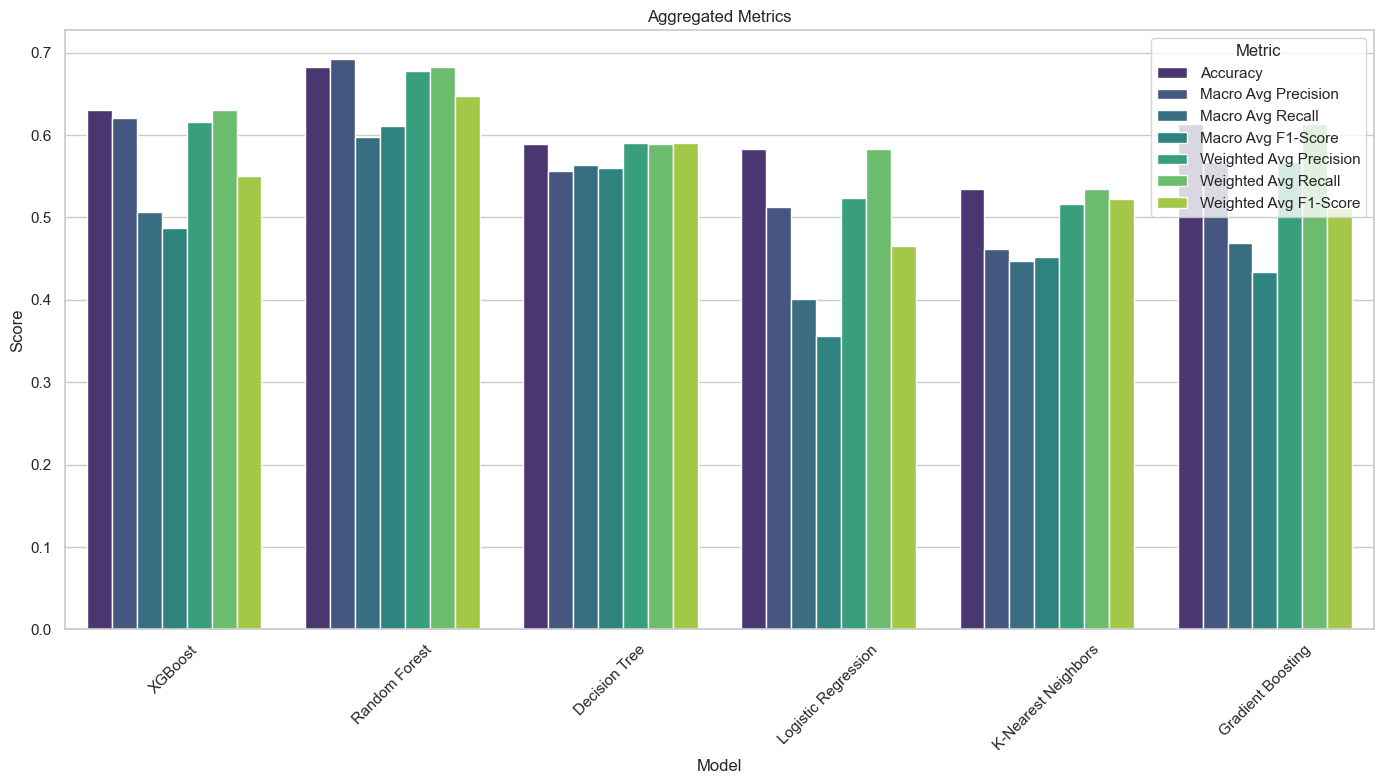

In [15]:
# Configuração do estilo dos gráficos
sns.set(style="whitegrid")

metrics = ['Accuracy', 'Macro Avg Precision', 'Macro Avg Recall', 'Macro Avg F1-Score', 
           'Weighted Avg Precision', 'Weighted Avg Recall', 'Weighted Avg F1-Score']
metrics_df = results_df.melt(id_vars=['Model'], value_vars=metrics,
                             var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df, palette="viridis")
plt.title('Aggregated Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# Caminho para o arquivo CSV
file_path = '../data/outputs/classification_reports.csv'

# Carregar os dados
df = pd.read_csv(file_path)
df.head()

,Model,Accuracy,Class 0 Precision,Class 0 Recall,Class 0 F1-Score,Class 1 Precision,Class 1 Recall,Class 1 F1-Score,Class 2 Precision,Class 2 Recall,Class 2 F1-Score,Macro Avg Precision,Macro Avg Recall,Macro Avg F1-Score,Weighted Avg Precision,Weighted Avg Recall,Weighted Avg F1-Score
0,XGBoost,0.629747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.621087,0.506711,0.486773,0.615526,0.629747,0.550262
1,Random Forest,0.682164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.692323,0.597163,0.610681,0.677507,0.682164,0.647270
2,Decision Tree,0.589439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.556828,0.563030,0.559803,0.590723,0.589439,0.590001
3,Logistic Regression,0.583341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.513220,0.400699,0.356299,0.523086,0.583341,0.465559
4,K-Nearest Neighbors,0.534123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.461308,0.446922,0.451436,0.515730,0.534123,0.522335


In [25]:
columns_to_drop = [
    'Class 0 Precision',
    'Class 0 Recall',
    'Class 0 F1-Score',
    'Class 1 Precision',
    'Class 1 Recall',
    'Class 1 F1-Score',
    'Class 2 Precision',
    'Class 2 Recall',
    'Class 2 F1-Score'
]

# Verificar quais colunas estão presentes no DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Remover as colunas
df_cleaned = df.drop(columns=existing_columns_to_drop)

# Salvar o DataFrame limpo em um novo arquivo CSV
df_cleaned.to_csv("../data/outputs/classification_reports_clean.csv", index=False)


In [26]:
# Caminho para o arquivo CSV
file_path = '../data/outputs/classification_reports_clean.csv'

# Carregar os dados
df = pd.read_csv(file_path)
df.head()

,Model,Accuracy,Macro Avg Precision,Macro Avg Recall,Macro Avg F1-Score,Weighted Avg Precision,Weighted Avg Recall,Weighted Avg F1-Score
0,XGBoost,0.629747,0.621087,0.506711,0.486773,0.615526,0.629747,0.550262
1,Random Forest,0.682164,0.692323,0.597163,0.610681,0.677507,0.682164,0.647270
2,Decision Tree,0.589439,0.556828,0.563030,0.559803,0.590723,0.589439,0.590001
3,Logistic Regression,0.583341,0.513220,0.400699,0.356299,0.523086,0.583341,0.465559
4,K-Nearest Neighbors,0.534123,0.461308,0.446922,0.451436,0.515730,0.534123,0.522335
